In [13]:
import matplotlib.pyplot as plt

In [14]:
# Define all structure
# Define type of slice and its parameters
slices = {
    'eMBB' : {
        'bandwidth_max': 100000000,
        'client_weight': 0.39,
        'usage_pattern': {
            'distribution': 'randint',
            'params': (4000000, 800000000)
        }
      },
      'URLLC' : {
        'bandwidth_max': 100000000,
        'client_weight': 0.39,
        'usage_pattern': {
            'distribution': 'randint',
            'params': (4000000, 800000000)
        }
      },
      'MIoT' : {
        'bandwidth_max': 100000000,
        'client_weight': 0.39,
        'usage_pattern': {
            'distribution': 'randint',
            'params': (4000000, 800000000)
          }
      },
      'mMTC' : {
        'bandwidth_max': 100000000,
        'client_weight': 0.39,
        'usage_pattern': {
            'distribution': 'randint',
            'params': (4000000, 800000000)
          }
      },
      'voice' : {
        'bandwidth_max': 100000000,
        'client_weight': 0.39,
        'usage_pattern': {
            'distribution': 'randint',
            'params': (4000000, 800000000)
          }
     }
}
          

# Define base station parameters
basestation = {
    'capacity_bandwidth': 20000000000,
    'coverage': 250,
    'ratios': {
        'URLLC': 0.01,
        'eMBB': 0.59,
        'mMTC': 0.05,
        'voice': 0.05,
        'MIoT': 0.2
    },
    'x': 150,
    'y': 150
}

# Define mobility patterns and its parameters
mobility_patterns = {
  'car': {
    'distribution': 'normal',
    'params':(0,7),
    'client_weight': 0.10
  },
  'walk': {
    'distribution': 'randint',
    'params': (-1, 1),
    'client_weight': 0.40
  },
  'stationary': {
    'distribution': 'normal',
    'params': (0, 0.1),
    'client_weight': 0.20
  },
  'tram': {
    'distribution': 'randint',
    'params': (-4, 4),
    'client_weight': 0.10
  },
  'slackperson':{
    'distribution': 'randint',
    'params':(0, 1),
    'client_weight': 0.20 
  }
}

# Define clients
clients = {
    'location': {
       'x': {
          'distribution': 'randint',
          'params': (0, 450)
       },
      'y': {
          'distribution': 'randint',
          'params': (0, 450)
       }
     },  
    'usage_frequency': {
        'distribution': 'randint',
        'params': (0, 100000)
    }
}



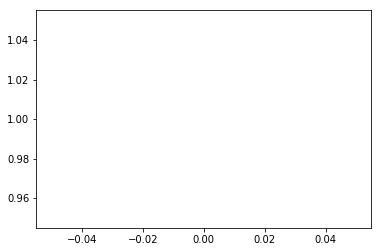

In [16]:
# Round 0: create network area, place base station and clients
num_clients = 200

plt.plot([1])
plt.show()